### Sequence
- Load trained G1, G2(one_sample) (e.g. model_3)
- Load dataset
- Measure error bound & ground truth
- Measure expected ground truth loss on G1 (gt_error_g1_no_boost save for later)
- Train G1 on the hard samples, or use oversampling (either from scratch, or from somewhere in the middle [e.g. model_2]) 
- Load G1_1 model
- Infer using a specific G1
- Measure expected ground truth loss using G1_0 or G1_1 on corresponding samples (gt_error_g1_with_boost)
- Check if gt_error_g1_with_boost < gt_error_g1_no_boost

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import sys
import os
import matplotlib.pyplot as plt
import scipy.stats
import math

# sys.path.insert(0, 'C:\projects\DLCourse\DistanceGAN_boosting')
# sys.path.insert(0, 'C:\projects\DLCourse\DistanceGAN_boosting\discogan_arch')
sys.path.insert(0, '/home/deepjunior/anaconda3/projects/gil_eyal_oran_csdl_proj/DistanceGAN_boosting')
sys.path.insert(0, '/home/deepjunior/anaconda3/projects/gil_eyal_oran_csdl_proj/DistanceGAN_boosting/discogan_arch')

from new_code.options import Options
from new_code import dataset
from new_code.disco_gan_with_risk import DiscoGANRisk
from new_code import utils

# Load trained G1, G2(one_sample) (e.g. model_3) $$$ Currently not all samples!!

In [2]:
not_all_samples = False

pretrained_g1_path_A='saved_models/discogan_shoes2edges_epochs98_g1'
pretrained_g1_path_B='saved_models/discogan_shoes2edges_epochs98_g1'
pretrained_g2_path_A='saved_models/discogan_shoes2edges_epochs98_g2_with_fixed_g1_one_sample'
pretrained_g2_path_B='saved_models/discogan_shoes2edges_epochs98_g2_with_fixed_g1_one_sample'

options_fixed = Options(task_name='edges2shoes', model_arch='discogan',which_epoch_load=3, not_all_samples=not_all_samples,
                        batch_size=64, fixed_g1=True, pretrained_g1_path_A=pretrained_g1_path_A,
                        pretrained_g1_path_B=pretrained_g1_path_B, pretrained_g2_path_A=pretrained_g2_path_A,
                        pretrained_g2_path_B=pretrained_g2_path_B)
fixed_disco_risk = DiscoGANRisk(options_fixed)

# Load dataset & measure error bound (SHOES -> EDGES)

In [3]:
data_a, data_b = dataset.get_edges2shoes()
n_min_data = min(len(data_a), len(data_b))
data_a = data_a[:n_min_data]
data_b = data_b[:n_min_data]
data_a_val, data_b_val = dataset.get_edges2shoes(test=True)

print('Data size: ',np.shape(data_a), np.shape(data_b))
print('Test size: ',np.shape(data_a_val), np.shape(data_b_val))

from discogan_arch import error_bound_calc_functions


model_number = 3 
## Load G1
G1_0_A = torch.load(os.path.join(pretrained_g1_path_A, 'model_gen_A-' + str(model_number)))
G1_0_B = torch.load(os.path.join(pretrained_g1_path_B, 'model_gen_B-' + str(model_number)))
G1_0_A = G1_0_A.cuda(0)
G1_0_B = G1_0_B.cuda(0)
## Load G2
G2_0_A = torch.load(os.path.join(pretrained_g2_path_A, 'model_gen_A-' + str(model_number)))
G2_0_B = torch.load(os.path.join(pretrained_g2_path_B, 'model_gen_B-' + str(model_number)))
G2_0_A = G2_0_A.cuda(0)
G2_0_B = G2_0_B.cuda(0)

G1_0_A.train(False)
G1_0_B.train(False)
G2_0_A.train(False)
G2_0_B.train(False)

J_loss_order, J_loss_val, groud_truth_loss = error_bound_calc_functions.samples_order_by_loss_from_filenames(
    data_b, data_a, G1_0_A, G2_0_A, G1_0_B, G2_0_B, options_fixed, n_batch=64, print_freq=100)


Data size:  (24912,) (24912,)
Test size:  (200,) (200,)


/home/deepjunior/anaconda3/lib/python3.6/site-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/deepjunior/anaconda3/lib/python3.6/site-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/deepjunior/anaconda3/lib/python3.6/site-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'torch.nn.modules.activation.LeakyReLU' has changed. you can retrieve the original source co

Number of samples:  24912
Number of iterations:  390
Completed  0  iterations ( 0 samples )
Completed  100  iterations ( 6400 samples )
Completed  200  iterations ( 12800 samples )
Completed  300  iterations ( 19200 samples )
Done calculating error bound & ground truth for all samples


# Train G1 on the hard samples, or use oversampling (either from scratch, or from somewhere in the middle [e.g. model_2]) 

### Start training from scratch - For shoes2edges we concatenate twice the hard samples, for edges2shoes we leave all of them unsorted

In [4]:
# g12_1_model_path = './models/boosting/from_scratch'
# options_boost = Options(task_name='edges2shoes', model_arch='discogan', epoch_size=1000, not_all_samples=not_all_samples,
#                         batch_size=64, model_path=g12_1_model_path)
# boost_disco_risk = DiscoGANRisk(options_boost)

In [5]:
# mid = int(np.round(len(data_b)/2))

# sorted_data_BA=[]
# for idx in range(len(J_loss_order)): # very dirty
#     sorted_data_BA.append(data_b[J_loss_order[idx]])
# sorted_data_BA = sorted_data_BA[:mid] + sorted_data_BA[:mid]
# sorted_data_AB = data_a

In [6]:
# boost_disco_risk.train(sorted_data_AB, sorted_data_BA, data_a_val, data_b_val)

/home/deepjunior/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


INFO:tensorflow:Directory watcher advancing from /home/deepjunior/anaconda3/projects/gil_eyal_oran_csdl_proj/DistanceGAN_boosting/results/log/events.out.tfevents.1514450025.deepjunior-dl to /home/deepjunior/anaconda3/projects/gil_eyal_oran_csdl_proj/DistanceGAN_boosting/results/log/events.out.tfevents.1514489559.deepjunior-dl
INFO:tensorflow:Directory watcher advancing from /home/deepjunior/anaconda3/projects/gil_eyal_oran_csdl_proj/DistanceGAN_boosting/results/log/events.out.tfevents.1514489559.deepjunior-dl to /home/deepjunior/anaconda3/projects/gil_eyal_oran_csdl_proj/DistanceGAN_boosting/results/log/events.out.tfevents.1514489932.deepjunior-dl
INFO:tensorflow:Directory watcher advancing from /home/deepjunior/anaconda3/projects/gil_eyal_oran_csdl_proj/DistanceGAN_boosting/results/log/events.out.tfevents.1514489932.deepjunior-dl to /home/deepjunior/anaconda3/projects/gil_eyal_oran_csdl_proj/DistanceGAN_boosting/results/log/events.out.tfevents.1514489945.deepjunior-dl
INFO:tensorflow:

INFO:tensorflow:Directory watcher advancing from /home/deepjunior/anaconda3/projects/gil_eyal_oran_csdl_proj/DistanceGAN_boosting/results/log/events.out.tfevents.1514573752.deepjunior-dl to /home/deepjunior/anaconda3/projects/gil_eyal_oran_csdl_proj/DistanceGAN_boosting/results/log/events.out.tfevents.1514576930.deepjunior-dl
INFO:tensorflow:Directory watcher advancing from /home/deepjunior/anaconda3/projects/gil_eyal_oran_csdl_proj/DistanceGAN_boosting/results/log/events.out.tfevents.1514576930.deepjunior-dl to /home/deepjunior/anaconda3/projects/gil_eyal_oran_csdl_proj/DistanceGAN_boosting/results/log/events.out.tfevents.1514577665.deepjunior-dl
INFO:tensorflow:Directory watcher advancing from /home/deepjunior/anaconda3/projects/gil_eyal_oran_csdl_proj/DistanceGAN_boosting/results/log/events.out.tfevents.1514577665.deepjunior-dl to /home/deepjunior/anaconda3/projects/gil_eyal_oran_csdl_proj/DistanceGAN_boosting/results/log/events.out.tfevents.1514577999.deepjunior-dl
INFO:tensorflow:

INFO:tensorflow:Directory watcher advancing from /home/deepjunior/anaconda3/projects/gil_eyal_oran_csdl_proj/DistanceGAN_boosting/results/log/events.out.tfevents.1514625352.deepjunior-dl to /home/deepjunior/anaconda3/projects/gil_eyal_oran_csdl_proj/DistanceGAN_boosting/results/log/events.out.tfevents.1514626053.deepjunior-dl
INFO:tensorflow:Directory watcher advancing from /home/deepjunior/anaconda3/projects/gil_eyal_oran_csdl_proj/DistanceGAN_boosting/results/log/events.out.tfevents.1514626053.deepjunior-dl to /home/deepjunior/anaconda3/projects/gil_eyal_oran_csdl_proj/DistanceGAN_boosting/results/log/events.out.tfevents.1514627140.deepjunior-dl
INFO:tensorflow:Directory watcher advancing from /home/deepjunior/anaconda3/projects/gil_eyal_oran_csdl_proj/DistanceGAN_boosting/results/log/events.out.tfevents.1514627140.deepjunior-dl to /home/deepjunior/anaconda3/projects/gil_eyal_oran_csdl_proj/DistanceGAN_boosting/results/log/events.out.tfevents.1514627324.deepjunior-dl
INFO:tensorflow:

INFO:tensorflow:Directory watcher advancing from /home/deepjunior/anaconda3/projects/gil_eyal_oran_csdl_proj/DistanceGAN_boosting/results/log/events.out.tfevents.1514669344.deepjunior-dl to /home/deepjunior/anaconda3/projects/gil_eyal_oran_csdl_proj/DistanceGAN_boosting/results/log/events.out.tfevents.1514669649.deepjunior-dl
INFO:tensorflow:Directory watcher advancing from /home/deepjunior/anaconda3/projects/gil_eyal_oran_csdl_proj/DistanceGAN_boosting/results/log/events.out.tfevents.1514669649.deepjunior-dl to /home/deepjunior/anaconda3/projects/gil_eyal_oran_csdl_proj/DistanceGAN_boosting/results/log/events.out.tfevents.1514670929.deepjunior-dl
INFO:tensorflow:Directory watcher advancing from /home/deepjunior/anaconda3/projects/gil_eyal_oran_csdl_proj/DistanceGAN_boosting/results/log/events.out.tfevents.1514670929.deepjunior-dl to /home/deepjunior/anaconda3/projects/gil_eyal_oran_csdl_proj/DistanceGAN_boosting/results/log/events.out.tfevents.1514671242.deepjunior-dl
INFO:tensorflow:

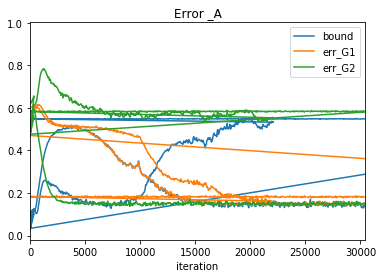

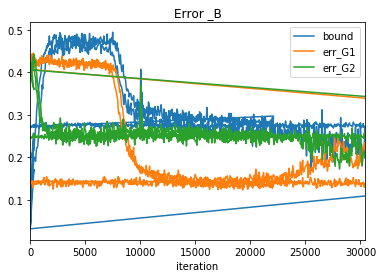

In [7]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import pandas as pd
%matplotlib inline
event_acc = EventAccumulator(r'/home/deepjunior/anaconda3/projects/gil_eyal_oran_csdl_proj/DistanceGAN_boosting/results/log')
event_acc.Reload()

def plot_errors(event_acc, domain):
    _, steps, err_vals = zip(*event_acc.Scalars('GT_Error{0}'.format(domain)))
    _, _, err_vals_G2 = zip(*event_acc.Scalars('GT_Error{0}_G2'.format(domain)))
    _, _, bound_vals = zip(*event_acc.Scalars('Bound{0}'.format(domain)))
    data = pd.DataFrame(data={'bound':bound_vals, 'err_G1':err_vals, 'err_G2':err_vals_G2}, index=steps)
    data.index.name='iteration'
    data.plot(title='Error {0}'.format(domain))

plot_errors(event_acc, '_A')
plot_errors(event_acc, '_B')

### Start train from a checkpoint For shoes2edges we concatenate twice the hard samples, for edges2shoes we leave all of them unsorted

In [8]:
model_number = 2
g12_1_model_path = './models/boosting/shoes2edges/from_checkpoint2_BA'

pretrained_g1_path_A='./saved_models/discogan_shoes2edges_epochs98_g2_with_fixed_g1_one_sample/py3'
pretrained_g1_path_B='./saved_models/discogan_shoes2edges_epochs98_g2_with_fixed_g1_one_sample/py3'
pretrained_g2_path_A='./saved_models/discogan_shoes2edges_epochs98_g2_with_fixed_g1_one_sample/py3'
pretrained_g2_path_B='./saved_models/discogan_shoes2edges_epochs98_g2_with_fixed_g1_one_sample/py3'

mid = int(np.round(len(data_b)/2))

sorted_data_BA=[]
for idx in range(len(J_loss_order)): # very dirty
    sorted_data_BA.append(data_b[J_loss_order[idx]])
sorted_data_BA = sorted_data_BA[:mid] + sorted_data_BA[:mid]
sorted_data_AB = data_a
print(len(sorted_data_BA))
print(len(sorted_data_AB))
print(len(data_a_val))
print(len(data_b_val))



options_boost = Options(task_name='edges2shoes', model_arch='discogan', which_epoch_load=model_number, epoch_size=78,
                        not_all_samples=not_all_samples, batch_size=64, fixed_g1=False,  
                        pretrained_g1_path_A=pretrained_g1_path_A, pretrained_g1_path_B=pretrained_g1_path_B, 
                        pretrained_g2_path_A=pretrained_g2_path_A, pretrained_g2_path_B=pretrained_g2_path_B, 
                        start_from_pretrained_g1=True, start_from_pretrained_g2=True, model_path=g12_1_model_path)
boost_disco_risk = DiscoGANRisk(options_boost)

24912
24912
200
200


In [9]:
# #### UNCOMMENT TO TRAIN

# boost_disco_risk.train(sorted_data_AB, sorted_data_BA, data_a_val, data_b_val)

### Load G1_1 model

In [10]:
model_number=3

G1_1_A = torch.load(os.path.join(g12_1_model_path, 'model_gen_A_G1-' + str(model_number)))
G1_1_B = torch.load(os.path.join(g12_1_model_path, 'model_gen_B_G1-' + str(model_number)))
G1_1_A = G1_1_A.cuda(0)
G1_1_B = G1_1_B.cuda(0)
G1_1_A.train(False)
G1_1_B.train(False)
G2_1_A = torch.load(os.path.join(g12_1_model_path, 'model_gen_A_G2-' + str(model_number)))
G2_1_B = torch.load(os.path.join(g12_1_model_path, 'model_gen_B_G2-' + str(model_number)))
G2_1_A = G1_1_A.cuda(0)
G2_1_B = G1_1_B.cuda(0)
G2_1_A.train(False)
G2_1_B.train(False)

from error_bound_calc_functions import *

### Infer using a specific G1 (Shoes2Edges, validation set) 

In [16]:
options_infer = Options(cuda='true', task_name='edges2shoes', model_arch='discogan',which_epoch_load=3)

#running G1_0 G2_0 on test data, and ordering by loss
J_loss_order_val, J_loss_val_val, groud_truth_loss_val = samples_order_by_loss_from_filenames(
    data_a_val, data_b_val, G1_0_B, G2_0_B, G1_0_A, G2_0_A, options_infer, n_batch=64, print_freq=100)

#if we got a Threshold from the training time, use it, if not - take the median of the loss on the test set as the threshold
# if thresh is None:
thresh = np.median(J_loss_val_val)
print('Treshold: ',thresh)

# idx's of images from the first round, that the error is lower than threshold
first_round_idx = np.where(J_loss_val_val <= thresh)
#idx's that the error is bigger than threshold, on these images we will run the boosting
second_round_idx = np.where(J_loss_val_val > thresh)

print('Low error - use G1_0: ',first_round_idx)
print('High error - use G1_1: ',second_round_idx)

from operator import itemgetter
# leave in the test set just the images for the second round
test_style_A = list(itemgetter(*second_round_idx[0].tolist())(data_a_val))
test_style_B = list(itemgetter(*second_round_idx[0].tolist())(data_b_val))
print('test data A: ',len(test_style_A))
print('test data B: ',len(test_style_B))
#run the second generators on the partial test set
J_loss_order_val2, J_loss_val_val2, groud_truth_loss_val2 = samples_order_by_loss_from_filenames(
    test_style_A, test_style_B, G1_1_B, G2_1_B, G1_1_A, G2_1_A, options_infer, n_batch=64, print_freq=100)

#calculate the average ground truth error if we didn't have boosting
original_ground_truth_loss = np.average(groud_truth_loss_val)

#calculate the average error with the boosting. taking the ground truth loss of first iteration only on idx's of first round,
#and adding the ground truth lost from the second iteration on the second iteration idx's
boosting_ground_truth_loss = np.average(np.concatenate((groud_truth_loss_val[first_round_idx],groud_truth_loss_val2)))

#hopefully the boosting loss will be smaller than the original loss
print("Original Loss: {:.3} Boosting Loss: {:.3}".format(original_ground_truth_loss, boosting_ground_truth_loss))

Number of samples:  200
Number of iterations:  4
Completed  0  iterations ( 0 samples )
Done calculating error bound & ground truth for all samples
Treshold:  0.180777147412
Low error - use G1_0:  (array([  1,   2,   3,   5,   6,  10,  11,  14,  16,  17,  20,  27,  29,
        30,  31,  34,  36,  40,  41,  43,  47,  49,  50,  60,  61,  62,
        63,  66,  69,  71,  72,  75,  76,  79,  80,  81,  83,  84,  87,
        88,  89,  91,  93,  94,  95,  96,  97,  98, 103, 106, 110, 112,
       113, 114, 118, 119, 121, 122, 123, 125, 129, 130, 132, 139, 143,
       145, 146, 148, 149, 150, 151, 152, 154, 155, 156, 157, 159, 160,
       162, 164, 167, 168, 170, 173, 174, 176, 178, 180, 182, 183, 184,
       185, 186, 187, 188, 191, 194, 197, 198, 199]),)
High error - use G1_1:  (array([  0,   4,   7,   8,   9,  12,  13,  15,  18,  19,  21,  22,  23,
        24,  25,  26,  28,  32,  33,  35,  37,  38,  39,  42,  44,  45,
        46,  48,  51,  52,  53,  54,  55,  56,  57,  58,  59,  64,  65,
  

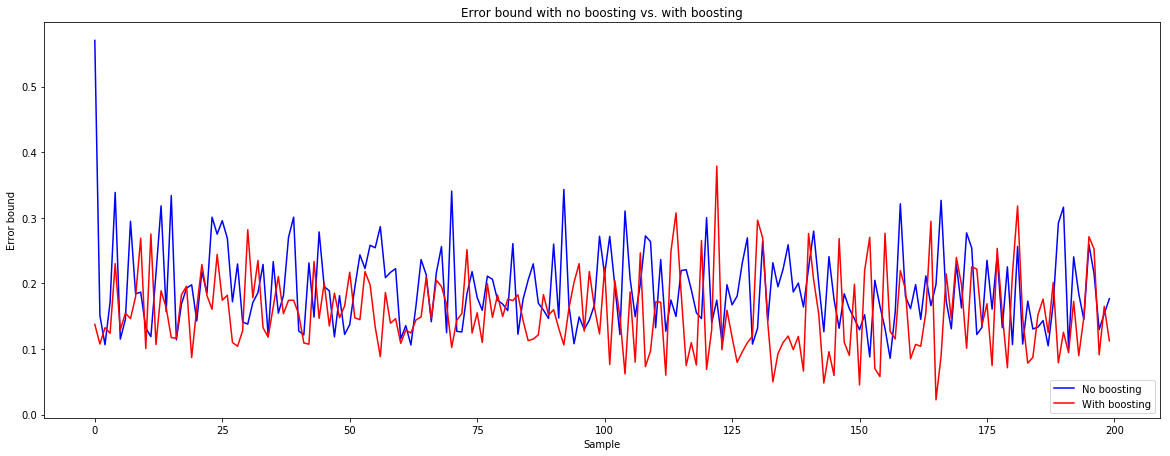

In [19]:
# Plots
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 16.0) 
plt.subplot(2,1,1)

plt.plot(J_loss_val_val, 'b')
plt.plot(np.concatenate((groud_truth_loss_val[first_round_idx],groud_truth_loss_val2)),'r')

plt.title('Error bound with no boosting vs. with boosting')
plt.xlabel('Sample')
plt.ylabel('Error bound')
plt.legend(['No boosting' ,'With boosting'], loc=4)

# plt.subplot(3,1,2)
# plt.plot(J_loss_val[:200], 'b')
# plt.plot(groud_truth_loss[:200],'r')

# plt.title('(Zoom in) Error bound vs. ground truth')
# plt.xlabel('Sample')
# plt.ylabel('Error')
# plt.legend(['Error bound' ,'Ground truth'], loc=4)


### Infer using a specific G1 (Shoes2Edges, validation set) 

### Infer using a specific G1 (Edges2Shoes, training set) 

### Infer using a specific G1 (Shoes2Edges, training set) 